### Data

* Pregnancies : 임신횟수* 
Glucose : 포도당 농도* 
BloodPressure : 혈* 압
SkinThickness : 피부* 두께
Insulin : * 인슐린
BMI : 체* 질량지수
DiabetesPedigreeFunction : 당뇨병 * 혈통 기능
Ag* e : 나이
Outcome : 당뇨병 여부(0: 발병되지 않음, 1: 발병)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        652 non-null    object 
 1   Pregnancies               652 non-null    int64  
 2   Glucose                   652 non-null    int64  
 3   BloodPressure             652 non-null    int64  
 4   SkinThickness             652 non-null    int64  
 5   Insulin                   652 non-null    int64  
 6   BMI                       652 non-null    float64
 7   DiabetesPedigreeFunction  652 non-null    float64
 8   Age                       652 non-null    int64  
 9   Outcome                   652 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 51.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ---

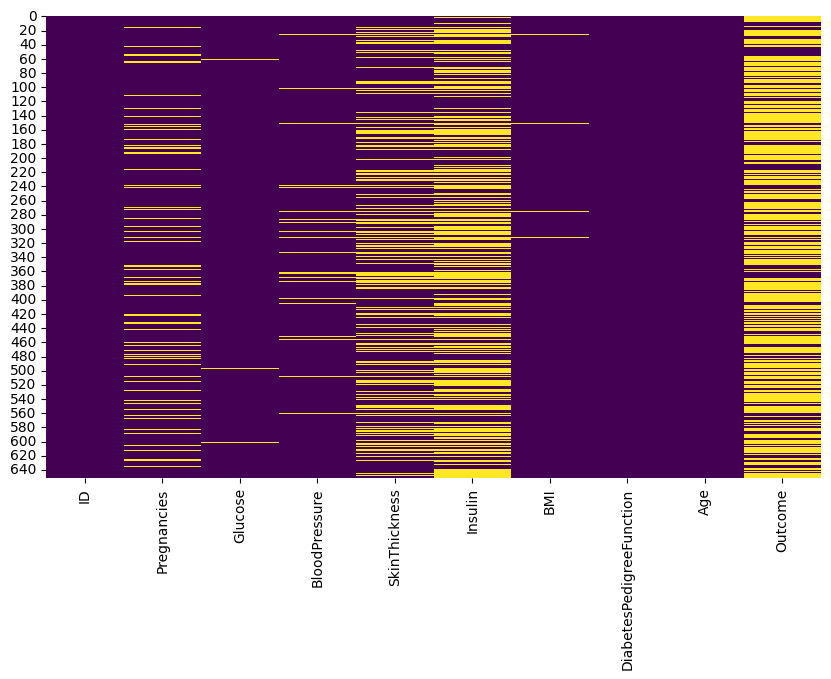

In [5]:
# isnull().sum()으로 확인했을 때 결측치가 없었으나 0으로 처리된 것들이 있었으므로,
# 0을 결측치로 간주하고 확인
train_zero = train.replace(0, np.nan)

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(train_zero.isnull(), cbar=False, cmap='viridis')
plt.show()

In [6]:
# Pregnancies와 Outcome은 0이 결측치가 아니므로 무시.
# Glucose, BloodPressure, SkinThickness, Insulin, BMI만 처리해주면 될 듯 하다.

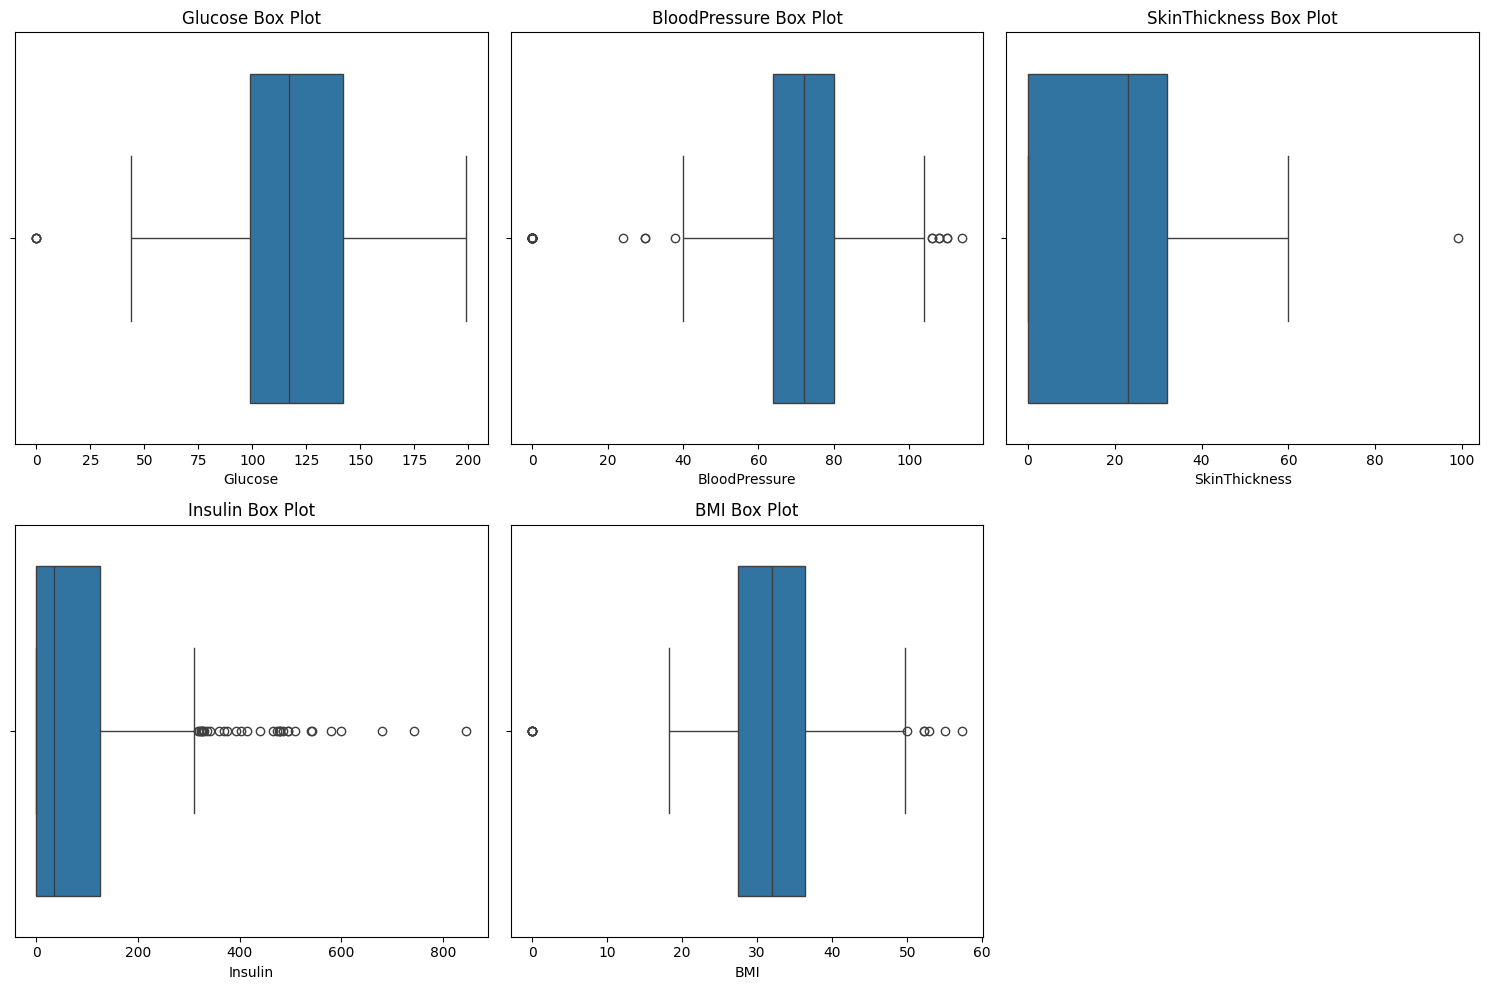

In [7]:
# 박스플롯을 이용한 이상치 확인
plt.figure(figsize=(15, 10))

for i, column in enumerate(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=train[column])
    plt.title(f'{column} Box Plot')

plt.tight_layout()
plt.show()

In [8]:
# Glucose, BloodPressure, SkinThickness, Insulin, BMI에 이상치도 존재한다.

# 공복일 때 인슐린 수치가 0일 수도 있다는 정보를 찾아, 인슐린은 0을 결측치로 처리하면 안될듯.
# 300부터 이상치로 잡히는데, 당뇨 환자의 경우 600까지도 잡히므로 수치가 많이 잡히는 500까지는 이상치로 처리하면 안될듯.
insulin = train['Insulin'].median()
train.loc[train['Insulin'] >= 500, 'Insulin'] = insulin
test.loc[test['Insulin'] >= 500, 'Insulin'] = insulin

# BMI는 50 이상이려면 170cm에 150kg이상이여야한다.
# 실제 데이터일 수 있지만 예외적 케이스이므로 이상치 처리해주는게 맞을듯.
bmi = train['BMI'].median()
train.loc[(train['BMI'] == 0) | (train['BMI'] >= 50), 'BMI'] = bmi
test.loc[(test['BMI'] == 0) | (test['BMI'] >= 50), 'BMI'] = bmi

# BloodPressure은 저혈압, 고혈압이 이상치로 잡힌 듯 하다.
# 당뇨에 영향이 있을 수 있으므로 0만 이상치라고 판단.
bloodpressure = train['BloodPressure'].median()
train.loc[train['BloodPressure'] == 0, 'BloodPressure'] = bloodpressure
test.loc[test['BloodPressure'] == 0, 'BloodPressure'] = bloodpressure

# Glucose는... 0일수가 있나? 값도 적고 Outcome도 달라서 이상치로 간주
glucose = train['Glucose'].median()
train.loc[train['Glucose'] == 0, 'Glucose'] = glucose
test.loc[test['Glucose'] == 0, 'Glucose'] = glucose

In [9]:
skin90 = train[train['SkinThickness'] >= 90]
print (skin90)

# SkinThickness가 90이상인 이상치가 99로 되어있다.
# 대충 직감으로 9의 오타라고 생각하고 9로 바꿔주자.

            ID  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
213  TRAIN_213            2      197             70             99        0   

      BMI  DiabetesPedigreeFunction  Age  Outcome  
213  34.7                     0.575   62        1  


In [10]:
train.loc[train['SkinThickness'] == 99, 'SkinThickness'] = 0
test.loc[test['SkinThickness'] == 99, 'SkinThickness'] = 0
skin90 = train[train['SkinThickness'] >= 90]
print (skin90) #잘 처리됐음

Empty DataFrame
Columns: [ID, Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


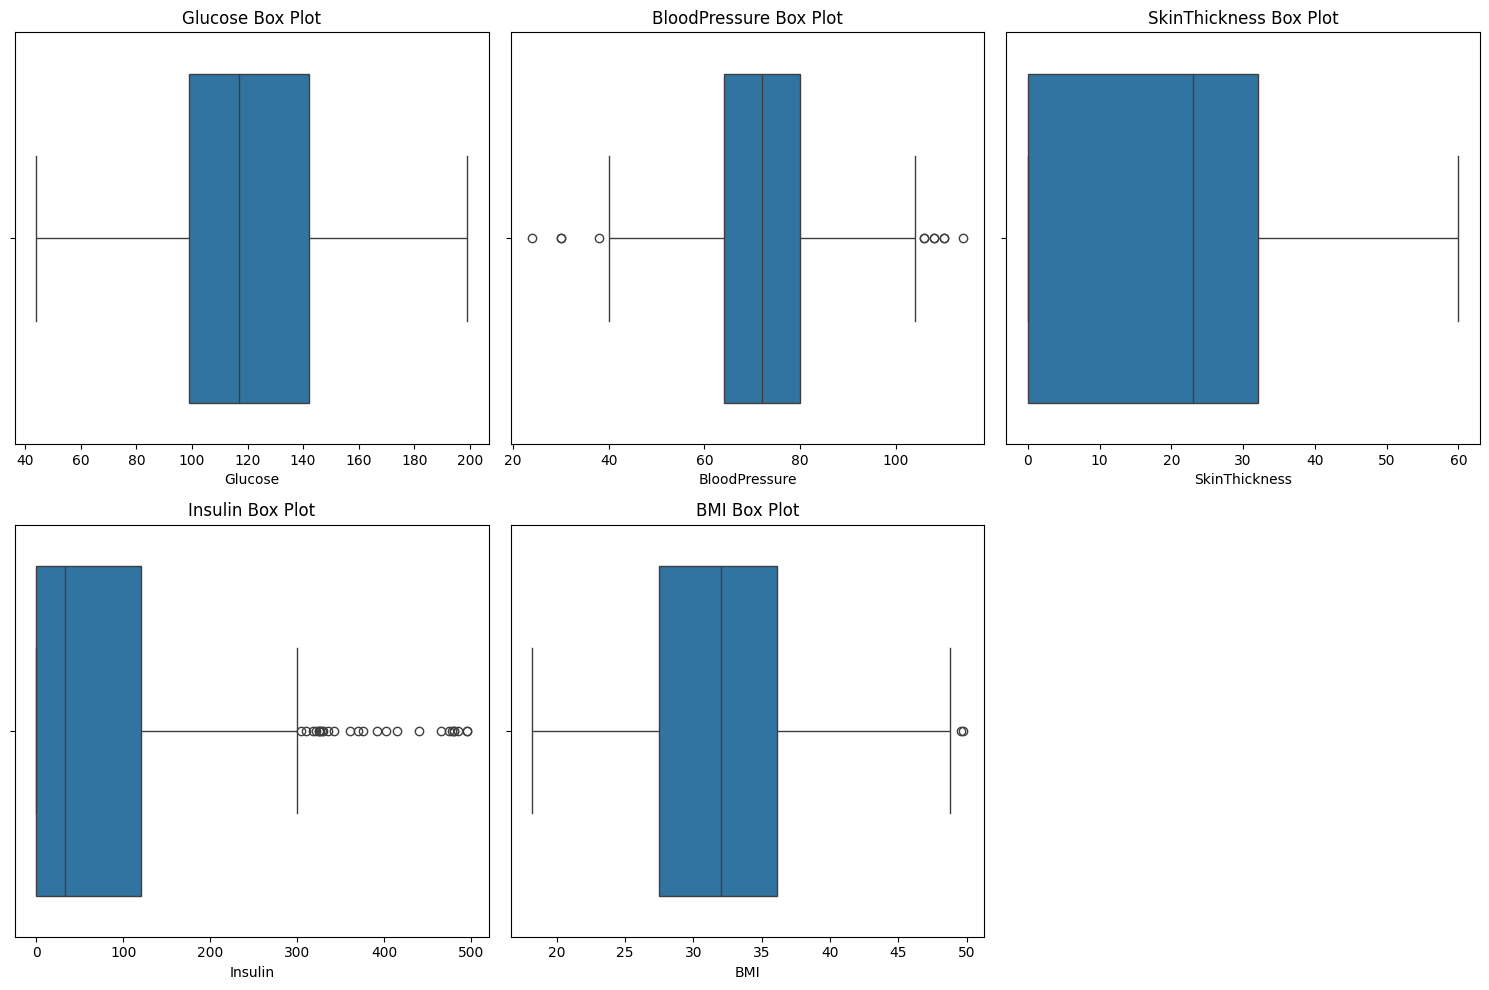

In [11]:
# 다시 확인. 만약 결과가 이상하면 그 때 이상치를 다 없애는걸로...
# + 4차 : 이상치를 모두 제거해봤는데 점수가 더 낮아진다. 이걸로 유지.

plt.figure(figsize=(15, 10))

for i, column in enumerate(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=train[column])
    plt.title(f'{column} Box Plot')

plt.tight_layout()
plt.show()

In [12]:
# feature와 target 분리

X = train.drop(columns=['ID', 'Outcome'])
y = train['Outcome']
X_test = test.drop(columns=['ID'])

In [13]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [15]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    voting='soft'
)

# 다양한 모델을 써보고 싶어서 처음에 Logistic Regression과 Decision Tree를 사용했는데 성능이 떨어지는 것 같아서 뺐다.
# 적절한 모델을 조금만 쓰는 판단력도 필요한듯.

In [16]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=kfold, scoring='roc_auc')
print("Cross-validation ROC-AUC scores:", cross_val_scores)
print("Mean cross-validation ROC-AUC:", np.mean(cross_val_scores))

voting_clf.fit(X_train_scaled, y_train)

Cross-validation ROC-AUC scores: [0.8079096  0.79728318 0.79989551 0.82183908 0.90836864]
Mean cross-validation ROC-AUC: 0.8270592024865842


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_typ...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [17]:
# Pseudolabeling / 테스트 데이터로 예측한 결과를 훈련 데이터에 추가
# GPT한테 물어본 기능. 성능 향상에 도움이 됐다.
pseudo_labels = voting_clf.predict(X_test_scaled)
pseudo_data = pd.DataFrame(X_test_scaled, columns=X.columns)
pseudo_data['Outcome'] = pseudo_labels

In [18]:
# 훈련 데이터를 확장
X_exp = np.vstack((X_train_scaled, X_test_scaled))
y_exp = np.hstack((y_train, pseudo_labels))

# 확장된 데이터로 다시 모델 학습
voting_clf.fit(X_exp, y_exp)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_typ...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [19]:
# Stacking 모델 구성
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(),
    cv=kfold
)

stacking_clf.fit(X_exp, y_exp)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression())

In [20]:
# Threshold 튜닝
y_pred_prob = stacking_clf.predict_proba(X_val_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

In [21]:
# 최적의 F1 Score를 위한 임계값 찾기
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold for F1 Score:", best_threshold)

# 최적 임계값을 이용한 최종 예측
y_pred_val = (y_pred_prob >= best_threshold).astype(int)

Best Threshold for F1 Score: 0.28556815194303875


In [22]:
# 최종 성능 평가
accuracy_val = accuracy_score(y_val, y_pred_val)
roc_auc_val = roc_auc_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)

print("Validation accuracy:", accuracy_val)
print("Validation ROC-AUC:", roc_auc_val)
print("Validation F1 Score:", f1_val)

Validation accuracy: 0.75
Validation ROC-AUC: 0.7540246212121212
Validation F1 Score: 0.6666666666666666


In [23]:
# 전체적으로 성능이 나쁘지 않은 듯...
# Validation set까지 포함한 전체 데이터로 모델 재학습해주고 끝.
X_final = np.vstack((X_train_scaled, X_val_scaled))
y_final = np.hstack((y_train, y_val))

voting_clf.fit(X_final, y_final)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_typ...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [24]:
# 최종 테스트 데이터 예측 및 저장
y_test_pred_prob = voting_clf.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_prob >= best_threshold).astype(int)

submission['Outcome'] = y_test_pred
submission.to_csv('submission.csv', index=False)